In [1]:
import pandas as pd
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('./podaci_klasifikacija/Train.csv')

In [3]:
print(train_df["ClassId"].unique())

[20  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


In [4]:
root_path = "./podaci_klasifikacija/"

In [5]:
random_image_path = root_path + "Train/14/00014_00000_00016.png"

In [6]:
random_image = cv2.imread(random_image_path)
random_image = cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB)

In [7]:
gray_image = cv2.cvtColor(random_image, cv2.COLOR_BGR2GRAY)

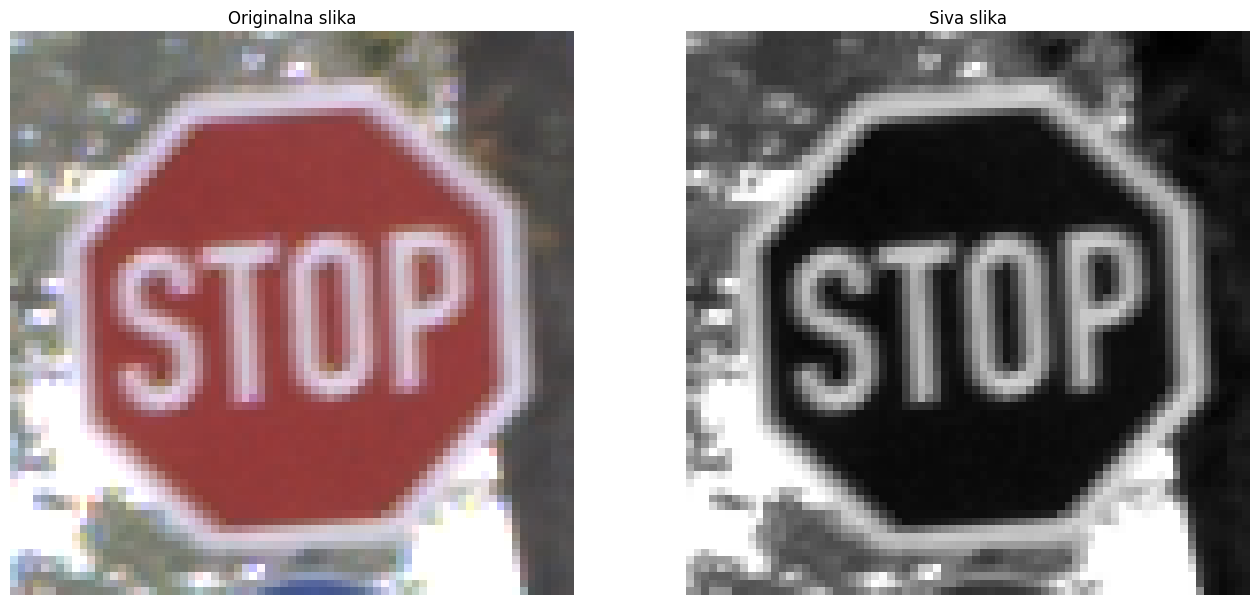

In [8]:
fig = plt.figure(figsize=(16,16))
fig.add_subplot(1,2,1)
plt.imshow(random_image)
plt.title("Originalna slika")
plt.axis("off")
fig.add_subplot(1,2,2)
plt.title("Siva slika")
plt.imshow(gray_image,cmap="gray")
plt.axis("off")
plt.show()

In [9]:
_, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)

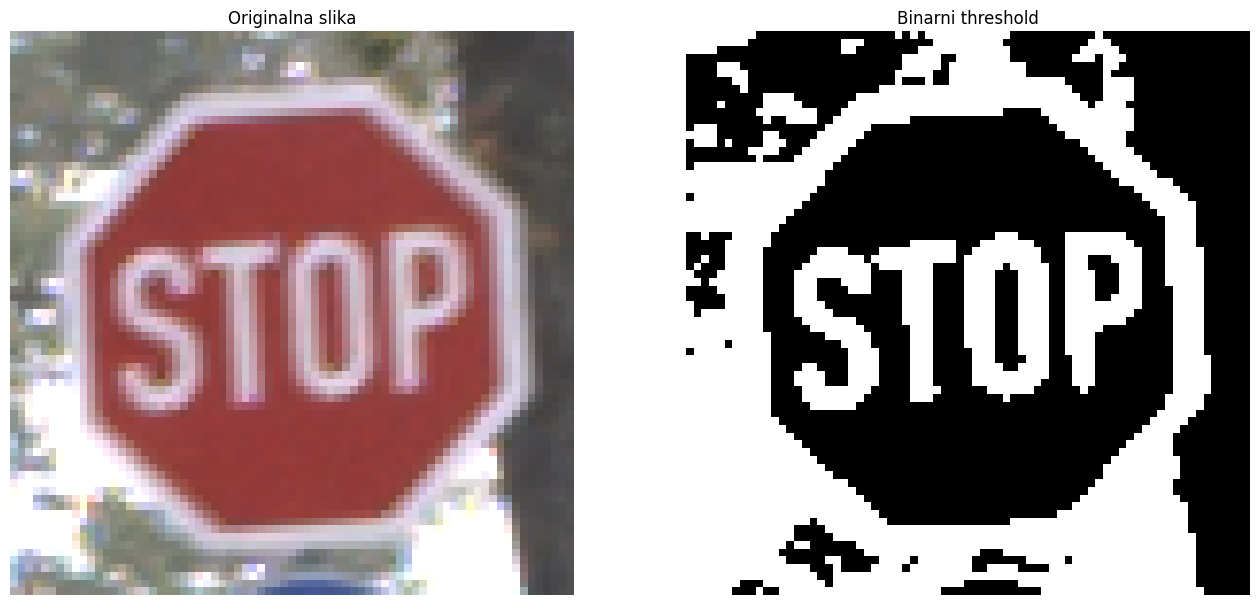

In [10]:
fig = plt.figure(figsize=(16,16))
fig.add_subplot(1,2,1)
plt.imshow(random_image)
plt.title("Originalna slika")
plt.axis("off")
fig.add_subplot(1,2,2)
plt.title("Binarni threshold")
plt.imshow(binary_image,cmap="gray")
plt.axis("off")
plt.show()

In [11]:
blurred_image = cv2.GaussianBlur(binary_image, (5, 5), 0)

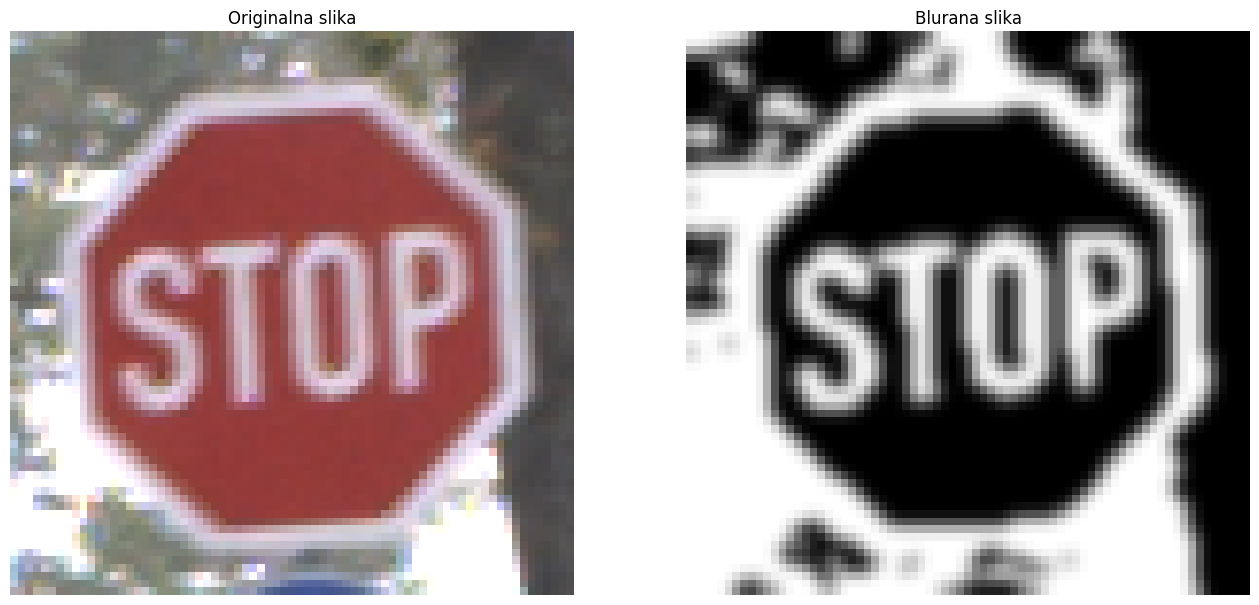

In [12]:
fig = plt.figure(figsize=(16,16))
fig.add_subplot(1,2,1)
plt.imshow(random_image)
plt.title("Originalna slika")
plt.axis("off")
fig.add_subplot(1,2,2)
plt.title("Blurana slika")
plt.imshow(blurred_image,cmap="gray")
plt.axis("off")
plt.show()

In [13]:
contours, _ = cv2.findContours(blurred_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
random_image_copy = random_image.copy()
cv2.drawContours(random_image_copy, contours, -1, (0, 255, 0), 2)

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [ 72,  71,  75],
        [ 70,  70,  73],
        [ 76,  78,  86]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [ 70,  68,  69],
        [ 73,  72,  71],
        [ 76,  75,  88]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [130, 142, 140],
        ...,
        [ 73,  70,  71],
        [ 78,  74,  73],
        [ 79,  74,  84]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [138, 140, 150],
        ...,
        [ 72,  72,  75],
        [ 73,  73,  75],
        [ 78,  78,  79]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [ 71,  70,  72],
        [ 75,  74,  74],
        [ 79,  78,  79]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [ 74,  71,  73],
        [ 78,  75,  76],
        [ 81,  78,  79]]

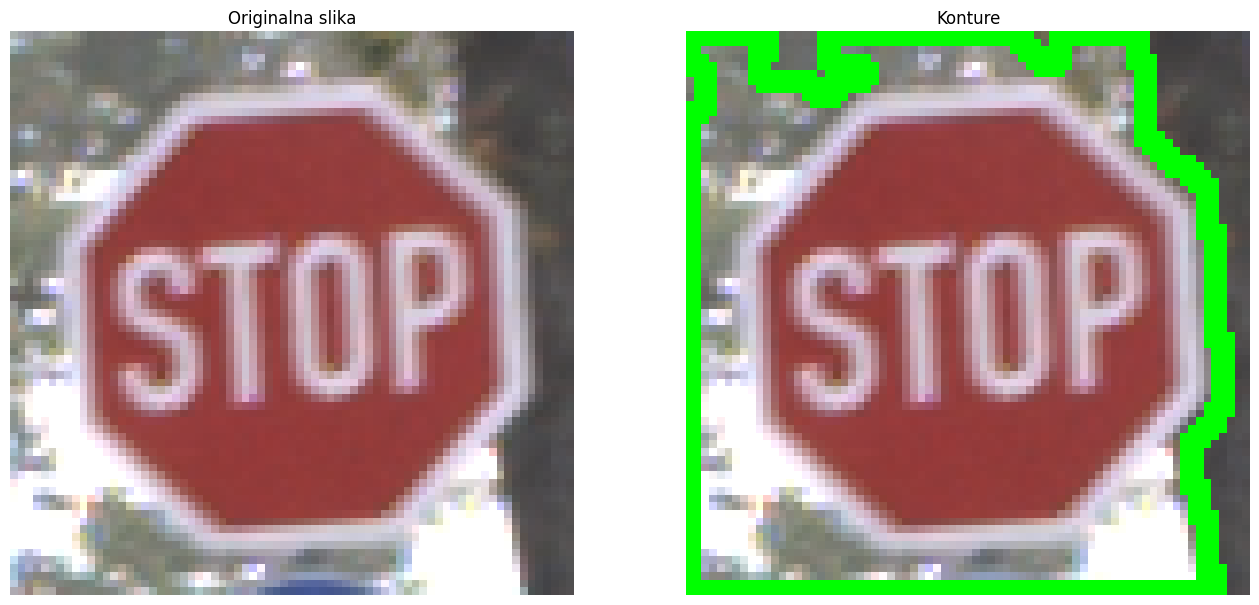

In [14]:
fig = plt.figure(figsize=(16,16))
fig.add_subplot(1,2,1)
plt.imshow(random_image)
plt.title("Originalna slika")
plt.axis("off")
fig.add_subplot(1,2,2)
plt.title("Konture")
plt.imshow(random_image_copy,cmap="gray")
plt.axis("off")
plt.show()

In [15]:
hog_feature,visualized = hog(random_image,orientations=9,pixels_per_cell=(8,8),
                              cells_per_block=(2,2),
                              visualize=True,
                              channel_axis=2)

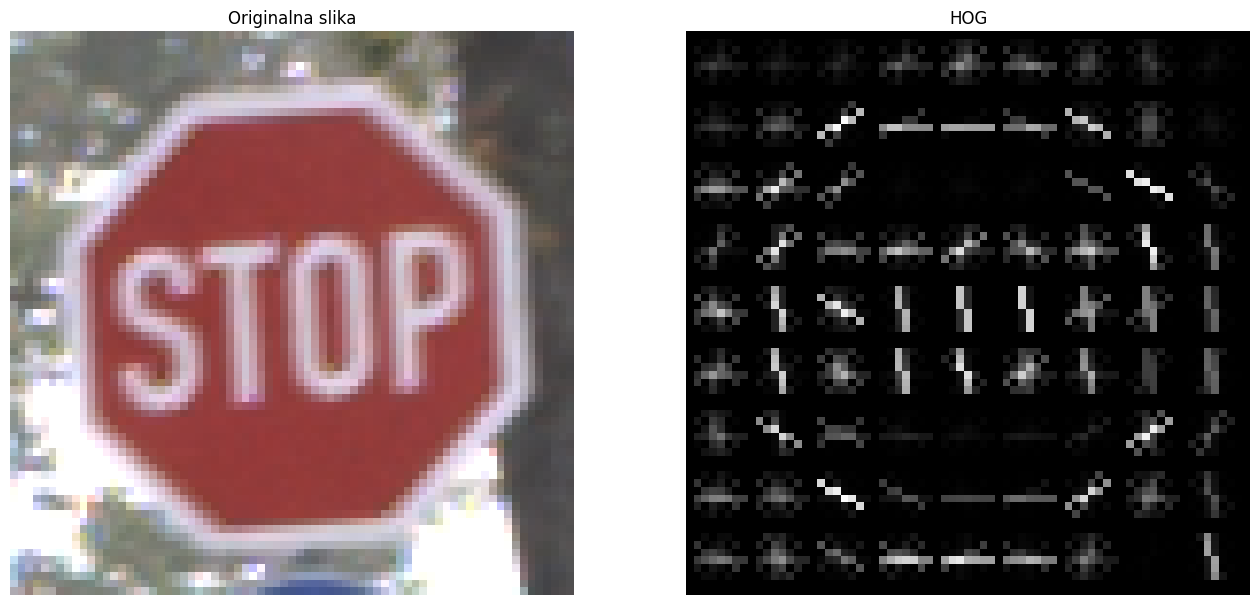

In [16]:
fig = plt.figure(figsize=(16,16))
fig.add_subplot(1,2,1)
plt.imshow(random_image)
plt.title("Originalna slika")
plt.axis("off")
fig.add_subplot(1,2,2)
plt.title("HOG")
plt.imshow(visualized,cmap="gray")
plt.axis("off")
plt.show()

In [17]:
def preprocess_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = np.uint8(gray_image)
    _, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)
    blurred_image = cv2.GaussianBlur(binary_image, (5, 5), 0)
    contours, _ = cv2.findContours(blurred_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image, contours, -1, (0, 255, 0), 2)
    return image

In [18]:
images = []
labels = []

In [19]:
for index, row in train_df.iterrows():
    img_path = root_path + row['Path']
    class_id = row['ClassId']
    img = cv2.imread(img_path)
    preprocessed_img = preprocess_image(img)
    img_resized = cv2.resize(preprocessed_img, (32, 32))
    img_rescaled = img_resized / 255.0
    images.append(img_rescaled)
    labels.append(class_id)

In [20]:
def extract_hog_features(images):
    hog_features = []
    for image in images:
        features = hog(image, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys', channel_axis=2)
        hog_features.append(features)
    return hog_features

In [21]:
images_features = extract_hog_features(images)

In [22]:
images_features = np.array(images_features)
labels = np.array(labels)

In [23]:
print ('HOG oblik slike: ',images_features.shape)
print ('Oznake oblik: ',labels.shape)

HOG oblik slike:  (39209, 324)
Oznake oblik:  (39209,)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(images_features, labels, test_size=0.2, random_state=42)

In [25]:
pca = PCA(n_components = 40)

In [26]:
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [27]:
print ('Oblik trening skupa: ',X_train.shape)
print ('Oblik test skupa: ',X_test.shape)

Oblik trening skupa:  (31367, 40)
Oblik test skupa:  (7842, 40)


In [28]:
svm_model = SVC(kernel='linear', gamma='scale')

In [29]:
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [30]:
y_pred = svm_model.predict(X_test)

In [31]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Preciznost treniranja: {accuracy*100} %")

Preciznost treniranja: 73.31038000510074 %


In [32]:
class_names = open("./podaci_klasifikacija/signnames.csv").read().strip().split("\n")[1:]
class_names = [l.split(",")[1] for l in class_names]

In [33]:
test_df = pd.read_csv("./podaci_klasifikacija/Test.csv")

In [35]:
test_labels = test_df['ClassId'].values.tolist()

In [36]:
test_images = []

In [37]:
for index, row in test_df.iterrows():
    img_path = root_path + row['Path']
    img = cv2.imread(img_path)
    preprocessed_img = preprocess_image(img)
    img_resized = cv2.resize(preprocessed_img, (32, 32))
    img_rescaled = img_resized / 255.0
    test_images.append(img_rescaled)

In [38]:
print("Testni podaci:",len(test_images))

Testni podaci: 12630


In [39]:
test_images_features = extract_hog_features(test_images)

In [40]:
test_images_features = np.array(test_images_features)
test_labels = np.array(test_labels)

In [42]:
test_images_features = pca.fit_transform(test_images_features)

In [43]:
predictions = svm_model.predict(test_images_features)

In [44]:
test_accuracy = accuracy_score(predictions, test_labels)
print(f"Preciznost testiranja: {test_accuracy*100} %")

Preciznost testiranja: 15.843230403800476 %
